In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import os

⏳ Loading Ensemble Models...


✅ Models Loaded.
Found 131 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
⏳ MobileNet Voting...
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 984ms/step
⏳ EfficientNet Voting...
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  

📊 ENSEMBLE MODEL RESULTS
              precision    recall  f1-score   support

    Existent       0.56      0.50      0.53        40
Non-existent       0.79      0.82      0.81        91

    accuracy                           0.73       131
   macro avg       0.67      0.66      0.67       131
weighted avg       0.72      0.73      0.72       131



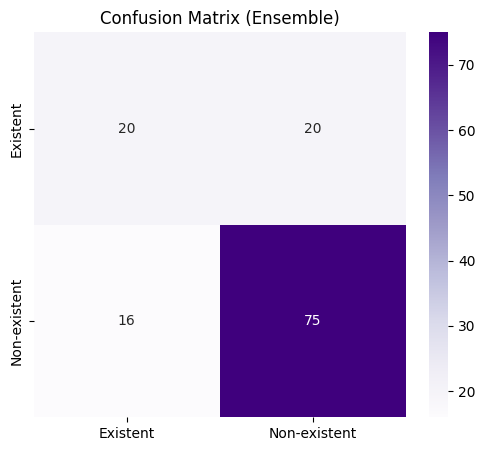

In [3]:
# ==========================================
# 1. SETUP
# ==========================================
TEST_CSV = "SurgWound_Cleaned/test_data.csv"
TEST_DIR = "SurgWound_Cleaned"

# Model Paths
MODEL_1_PATH = "erythema_model_finetuned.h5"       # MobileNet
MODEL_2_PATH = "erythema_efficientnet_robust.h5"   # EfficientNet

print("⏳ Loading Ensemble Models...")
if not os.path.exists(MODEL_1_PATH) or not os.path.exists(MODEL_2_PATH):
    print("❌ ERROR: One of the models is missing! Check your filenames.")
else:
    model_mobile = tf.keras.models.load_model(MODEL_1_PATH)
    model_efficient = tf.keras.models.load_model(MODEL_2_PATH)
    print("✅ Models Loaded.")

    # ==========================================
    # 2. PREPARE DATA
    # ==========================================
    test_df = pd.read_csv(TEST_CSV)
    test_df = test_df[test_df['image_id'].str.contains("erythema", case=False)]
    test_df['answer'] = test_df['answer'].astype(str)
    
    # --- Generator A: For MobileNet (Rescaled 0-1) ---
    gen_mobile = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=test_df, directory=TEST_DIR, x_col="filename", y_col="answer",
        target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False
    )

    # --- Generator B: For EfficientNet (Raw 0-255) ---
    gen_efficient = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_dataframe(
        dataframe=test_df, directory=TEST_DIR, x_col="filename", y_col="answer",
        target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False
    )

    # ==========================================
    # 3. RUN PREDICTIONS
    # ==========================================
    print("⏳ MobileNet Voting...")
    pred_mobile = model_mobile.predict(gen_mobile, verbose=1)
    
    print("⏳ EfficientNet Voting...")
    pred_efficient = model_efficient.predict(gen_efficient, verbose=1)

    # ==========================================
    # 4. ENSEMBLE AVERAGING
    # ==========================================
    # We Average the probabilities
    pred_ensemble = (pred_mobile + pred_efficient) / 2.0
    
    # Convert to Class IDs
    y_pred = np.argmax(pred_ensemble, axis=1)
    y_true = gen_mobile.classes # True labels are same for both

    # Get Class Names
    class_labels = {v: k for k, v in gen_mobile.class_indices.items()}
    class_names = [class_labels[i] for i in range(len(class_labels))]

    # ==========================================
    # 5. RESULTS
    # ==========================================
    print("\n" + "="*40)
    print("📊 ENSEMBLE MODEL RESULTS")
    print("="*40)
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Ensemble)')
    plt.show()

In [4]:
# ==========================================
# 1. SETUP
# ==========================================
TEST_CSV = "SurgWound_Cleaned/test_data.csv"
TEST_DIR = "SurgWound_Cleaned"

# Load the two "Best" Models
MODEL_1_PATH = "erythema_model_finetuned.h5"       # Best Sensitivity
MODEL_2_PATH = "erythema_efficientnet_robust.h5"   # Best Potential

print("⏳ Loading Models for Ensemble Tuning...")
if not os.path.exists(MODEL_1_PATH) or not os.path.exists(MODEL_2_PATH):
    print("❌ Error: Models not found. Make sure filenames are correct!")
else:
    model_mobile = tf.keras.models.load_model(MODEL_1_PATH)
    model_efficient = tf.keras.models.load_model(MODEL_2_PATH)

    # ==========================================
    # 2. GENERATE PREDICTIONS
    # ==========================================
    test_df = pd.read_csv(TEST_CSV)
    test_df = test_df[test_df['image_id'].str.contains("erythema", case=False)]
    test_df['answer'] = test_df['answer'].astype(str)
    
    # Generator A: MobileNet (Rescaled)
    gen_mobile = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=test_df, directory=TEST_DIR, x_col="filename", y_col="answer",
        target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False
    )

    # Generator B: EfficientNet (Raw)
    gen_efficient = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_dataframe(
        dataframe=test_df, directory=TEST_DIR, x_col="filename", y_col="answer",
        target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False
    )

    print("⏳ Running Predictions...")
    pred_mobile = model_mobile.predict(gen_mobile, verbose=1)
    pred_efficient = model_efficient.predict(gen_efficient, verbose=1)

    # AVERAGE THE PROBABILITIES (Class 0 = Existent)
    # This is the "Ensemble Score"
    ensemble_probs = (pred_mobile[:, 0] + pred_efficient[:, 0]) / 2.0
    
    y_true = gen_mobile.classes

    # ==========================================
    # 3. THRESHOLD SEARCH
    # ==========================================
    print("\n" + "="*60)
    print(f"ENSEMBLE THRESHOLD ANALYSIS")
    print("-" * 60)
    print(f"{'Threshold':<10} | {'Recall (Catch Rate)':<20} | {'Precision':<10} | {'Accuracy':<10}")
    print("="*60)

    for thresh in np.arange(0.1, 0.95, 0.05):
        # Logic: If Average Score > Threshold -> Predict 0 (Existent)
        y_pred_thresh = [0 if p > thresh else 1 for p in ensemble_probs]
        
        # Calculate Metrics
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_thresh, labels=[0], zero_division=0)
        acc = np.mean(np.array(y_pred_thresh) == y_true)
        
        print(f"{thresh:.2f}       | {recall[0]:.2%}             | {precision[0]:.2%}     | {acc:.2%}")

    print("="*60)

⏳ Loading Models for Ensemble Tuning...


Found 131 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
⏳ Running Predictions...


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019205C157E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 647ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 918ms/step

ENSEMBLE THRESHOLD ANALYSIS
------------------------------------------------------------
Threshold  | Recall (Catch Rate)  | Precision  | Accuracy  
0.10       | 92.50%             | 32.46%     | 38.93%
0.15       | 87.50%             | 35.00%     | 46.56%
0.20       | 82.50%             | 35.87%     | 49.62%
0.25       | 80.00%             | 38.55%     | 54.96%
0.30       | 72.50%             | 39.73%     | 58.02%
0.35       | 65.00%             | 43.33%     | 63.36%
0.40       | 62.50%             | 49.02%     | 68.70%
0.45       | 52.50%             | 52.50%     | 70.99%
0.50       | 50.00%             | 55.56%     | 72.52%
0.55       | 45.00%             | 66.67%     | 76.34%
0.60       | 30.00%             | 63.16%     | 73.28%
0.65       | 22.50%             | 64.29%     | 72.52%
0.70       | 17.50%             | 63.64%     | 71.76%
0.75       | 12.50%             | 55.56%     | 70.23%
0.80       | 12.